# Import and Config

In [1]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz import (
    LemmaVectorizer,
    FourierPDF,
    FuzzyFourierSetMixin,
    FourierFuzzifier,
    FuzzyFourierTensorTransformer,
    SpacyDependencyComposer
)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
spacy_model = spacy.load("en_core_web_sm")
lemma_vectorizer = LemmaVectorizer()
fuzzifier = FuzzyFourierTensorTransformer()


# Load Dataset

In [4]:
import wget as wget
wget.download("https://pilehvar.github.io/wic/package/WiC_dataset.zip")

'WiC_dataset (12).zip'

In [5]:
import zipfile
import os

# Define the path to your zip file and the target directory for extraction
zip_file_path = 'WiC_dataset.zip'
extract_dir = 'WiC_dataset'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file in read mode ('r')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_dir)

print(f"Contents of '{zip_file_path}' extracted to '{extract_dir}'")

Contents of 'WiC_dataset.zip' extracted to 'WiC_dataset'


In [6]:
import pandas as pd

train_df = pd.read_csv("./WiC_dataset/train/train.data.txt", sep="\t", header=None)
train_df.columns = ["lemma", "pos", "index1-index2", "sent_1", "sent_2"]

# clean dataframe
train_df["pos"] = train_df["pos"].apply(lambda x: x.lower())
train_df["tok_idx_1"] = train_df["index1-index2"].apply(lambda x: int(x.split("-")[0]))
train_df["tok_idx_2"] = train_df["index1-index2"].apply(lambda x: int(x.split("-")[1]))
train_df.drop("index1-index2", axis=1, inplace=True)

train_df.head()

,lemma,pos,sent_1,sent_2,tok_idx_1,tok_idx_2
0,carry,v,You must carry your camping gear .,Sound carries well over water .,2,1
1,go,v,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,2,6
2,break,v,Break an alibi .,The wholesaler broke the container loads into ...,0,2
3,cup,n,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,8,4
4,academy,n,The Academy of Music .,The French Academy .,1,2


# Vectorize, Fuzzify Dataset

## Vectorize, fuzzify

In [7]:
def get_branch_tuple_embedding(branch: tuple|spacy.tokens.Token):
    if isinstance(branch, tuple):
        return tuple([get_branch_tuple_embedding(t) for t in branch])
    elif isinstance(branch, spacy.tokens.Token):
        # lemma_vectorizer returns a numpy array, so convert it to tf.Tensor for fuzzification
        current_tok_tens = lemma_vectorizer(branch.lemma_.lower())
        current_tok_tens = tf.convert_to_tensor(current_tok_tens, dtype=tf.float32)
        return fuzzifier.fuzzify(current_tok_tens)

In [8]:
embedding_dict = dict()
for i in [1, 2]:
    embedding_dict.update({
        f"branch_tuple_embedding_{i}": list(),
        f"branch_text_{i}": list(),
        f"branch_text_embedding_{i}": list(),
    })

for i, row in train_df[:200].iterrows():
    
    for j in [1, 2]:
        doc = spacy_model(row[f"sent_{j}"])
        tok = doc[row[f"tok_idx_{j}"]]

        tok_lefts = [t for t in tok.lefts]
        tok_rights = [t for t in tok.rights if not t.is_punct]
        branch = tok_lefts + [tok] + tok_rights

        branch_tuple_embedding = get_branch_tuple_embedding((
            tuple(tok_lefts),
            (tok, ),
            tuple(tok_rights)
        ))
        branch_text = " ".join([t.text for t in branch])
        branch_text_embedding = embedding_model.encode(branch_text).tolist()

        # store in dataframe
        embedding_dict[f"branch_tuple_embedding_{j}"].append(branch_tuple_embedding)
        embedding_dict[f"branch_text_{j}"].append(branch_text)
        embedding_dict[f"branch_text_embedding_{j}"].append(branch_text_embedding)

In [9]:
embedding_df = pd.DataFrame.from_dict(embedding_dict)
embedding_df = pd.concat([train_df[:200].reset_index(drop=True), embedding_df], axis=1)
embedding_df.head()

,lemma,pos,sent_1,sent_2,tok_idx_1,tok_idx_2,branch_tuple_embedding_1,branch_text_1,branch_text_embedding_1,branch_tuple_embedding_2,branch_text_2,branch_text_embedding_2
0,carry,v,You must carry your camping gear .,Sound carries well over water .,2,1,(((tf.Tensor(\n[0.00338854-2.8324742e-03j 0.00...,You must carry gear,"[-0.029455117881298065, 0.014959510415792465, ...",(((tf.Tensor(\n[0.0043277 -6.1928941e-04j 0.00...,Sound carries over,"[0.03301728144288063, -0.04025080427527428, 0...."
1,go,v,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,2,6,(((tf.Tensor(\n[0.0043698 -1.7961758e-05j 0.00...,Messages must go through,"[0.052632834762334824, -0.03701762855052948, 0...",(((tf.Tensor(\n[0.00379175+2.2262512e-03j 0.00...,sofa will go through,"[0.09874849766492844, -0.051114026457071304, -..."
2,break,v,Break an alibi .,The wholesaler broke the container loads into ...,0,2,"((), ((tf.Tensor(\n[0.00409203-1.5697419e-03j ...",Break alibi,"[-0.0074392096139490604, 0.07352712750434875, ...",(((tf.Tensor(\n[0.00377977-2.2476572e-03j 0.00...,wholesaler broke loads into,"[-0.08407348394393921, -0.015558857470750809, ..."
3,cup,n,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,8,4,(((tf.Tensor(\n[0.00426647-9.6678629e-04j 0.00...,a metal cup,"[-0.02742213010787964, 0.07205650210380554, 0....",(((tf.Tensor(\n[0.00419467-1.2535643e-03j 0.00...,the waxen cups,"[-0.01649600639939308, 0.02845943346619606, 0...."
4,academy,n,The Academy of Music .,The French Academy .,1,2,(((tf.Tensor(\n[0.00419467-1.2535643e-03j 0.00...,The Academy of,"[-0.07165632396936417, -0.004963829647749662, ...",(((tf.Tensor(\n[0.00419467-1.2535643e-03j 0.00...,The French Academy,"[-0.05268881469964981, 0.00687433360144496, -0..."


## Compose fuzzy embeddings

In [10]:
composers = {
    s: SpacyDependencyComposer(
        strategy=s,
        fuzzifier=fuzzifier
    )
    for s in STRATEGIES
}

gloss_vect_fuzzy_cols = dict()
for i in [1, 2]:
    gloss_vect_fuzzy_cols.update({
        (s, i): f"sent_{i}_fuzzy_{s}"
        for s in STRATEGIES
    })

In [11]:
# get compositional embeddings for glosses using different strategies

tup_emb_args_1 = embedding_df[["branch_tuple_embedding_1", "pos"]].apply(lambda x: tuple(x), axis=1)
tup_emb_args_2 = embedding_df[["branch_tuple_embedding_2", "pos"]].apply(lambda x: tuple(x), axis=1)
for s, composer in composers.items():
  print(f"Getting compositional embeddings with {s} approach...")
  # compose embeddings
  embedding_df[gloss_vect_fuzzy_cols[(s, 1)]] = tup_emb_args_1.apply(lambda x: composer(x[0], x[1]))
  embedding_df[gloss_vect_fuzzy_cols[(s, 2)]] = tup_emb_args_2.apply(lambda x: composer(x[0], x[1]))

Getting compositional embeddings with None approach...
Getting compositional embeddings with mean approach...
Getting compositional embeddings with intersection+mean approach...
Getting compositional embeddings with intersection+union approach...
Getting compositional embeddings with intersection+intersection approach...
Getting compositional embeddings with selective_intersection+mean approach...
Getting compositional embeddings with selective_intersection+union approach...
Getting compositional embeddings with selective_intersection+intersection+mean approach...


# Evaluate model

## Config

In [30]:
# npsd-ot seems to do best for the fuzzy intersection+mean composition model
sim_metric = "npsd-ot"

sim = tf.keras.losses.CosineSimilarity(
    axis=-1,
    reduction='sum_over_batch_size',
    name='cosine_similarity'
)
def cosine_similarity(a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
  return -1*sim(a, b).numpy()

# Evaluate Compositional Models

In [31]:
sims_df = pd.DataFrame()

In [32]:
# Load ground truth labels
train_labels = pd.read_csv("./WiC_dataset/train/train.gold.txt", header=None)
train_labels.columns = ["is_related"]
train_labels = train_labels[:200]  # Match the subset size
train_labels["is_related"] = train_labels["is_related"].apply(lambda x: 1 if x == "T" else 0)

# get compositional embeddings for glosses using different strategies
for s, composer in composers.items():
  print(f"Getting compositional embedding relatedness scores with {s} approach...")
  sent_1_comp_emb_col = gloss_vect_fuzzy_cols[(s, 1)]
  sent_2_comp_emb_col = gloss_vect_fuzzy_cols[(s, 2)]

  sims = list()
  for i, row in embedding_df.iterrows():
    sims.append(fuzzifier.similarity(
        row[sent_1_comp_emb_col],
        row[sent_2_comp_emb_col],
        sim_metric
    ))
  
  col = f"fuzzy_{s}_{sim_metric}_sim"
  sims_df[col] = pd.Series(sims)
  # normalize similarity scores
  sims_df[col] = (sims_df[col] - sims_df[col].min()) / (sims_df[col].max() - sims_df[col].min())

# Add sentence embedding baseline
sent_emb_sims = list()
for i, row in embedding_df.iterrows():
  sent_emb_sims.append(cosine_similarity(
      tf.constant(row["branch_text_embedding_1"]),
      tf.constant(row["branch_text_embedding_2"])
  ))
  
col = "sent_emb_cos_sim"
sims_df[col] = pd.Series(sent_emb_sims)
# normalize similarity scores
sims_df[col] = (sims_df[col] - sims_df[col].min()) / (sims_df[col].max() - sims_df[col].min())
sims_df["is_related"] = train_labels["is_related"].values
sims_df.head()

Getting compositional embedding relatedness scores with None approach...
Getting compositional embedding relatedness scores with mean approach...
Getting compositional embedding relatedness scores with intersection+mean approach...
Getting compositional embedding relatedness scores with intersection+union approach...
Getting compositional embedding relatedness scores with intersection+intersection approach...
Getting compositional embedding relatedness scores with selective_intersection+mean approach...
Getting compositional embedding relatedness scores with selective_intersection+union approach...
Getting compositional embedding relatedness scores with selective_intersection+intersection+mean approach...


,fuzzy_None_npsd-ot_sim,fuzzy_mean_npsd-ot_sim,fuzzy_intersection+mean_npsd-ot_sim,fuzzy_intersection+union_npsd-ot_sim,fuzzy_intersection+intersection_npsd-ot_sim,fuzzy_selective_intersection+mean_npsd-ot_sim,fuzzy_selective_intersection+union_npsd-ot_sim,fuzzy_selective_intersection+intersection+mean_npsd-ot_sim,sent_emb_cos_sim,is_related
0,0.848680,0.607792,0.734201,0.605386,0.605386,0.725408,0.605386,0.723899,0.229827,0
1,0.796393,0.625516,0.829474,0.721565,0.721565,0.727092,0.721565,0.726632,0.231157,0
2,0.915510,0.405804,0.823832,0.884280,0.884280,0.726992,0.884280,0.730459,0.132000,0
3,0.926937,0.544518,0.844597,0.657329,0.657329,0.486603,0.746443,0.486603,0.410223,1
4,0.874650,0.643883,0.789190,0.746479,0.746479,0.598603,0.746490,0.598603,0.717832,0


In [38]:
sim_eval_df = pd.DataFrame()
for col in sims_df.columns:
    if col == "is_related":
        continue
    # normaize the 
    sim_eval_df[f"{col}_pred"] = sims_df[col] > sims_df[col].mean()
sim_eval_df["is_related"] = sims_df["is_related"]
sim_eval_df.head()

,fuzzy_None_npsd-ot_sim_pred,fuzzy_mean_npsd-ot_sim_pred,fuzzy_intersection+mean_npsd-ot_sim_pred,fuzzy_intersection+union_npsd-ot_sim_pred,fuzzy_intersection+intersection_npsd-ot_sim_pred,fuzzy_selective_intersection+mean_npsd-ot_sim_pred,fuzzy_selective_intersection+union_npsd-ot_sim_pred,fuzzy_selective_intersection+intersection+mean_npsd-ot_sim_pred,sent_emb_cos_sim_pred,is_related
0,True,True,False,False,False,True,False,True,False,0
1,False,True,True,True,True,True,True,True,False,0
2,True,False,True,True,True,True,True,True,False,0
3,True,False,True,False,False,False,True,False,False,1
4,True,True,True,True,True,False,True,False,True,0


## Visualize similarities

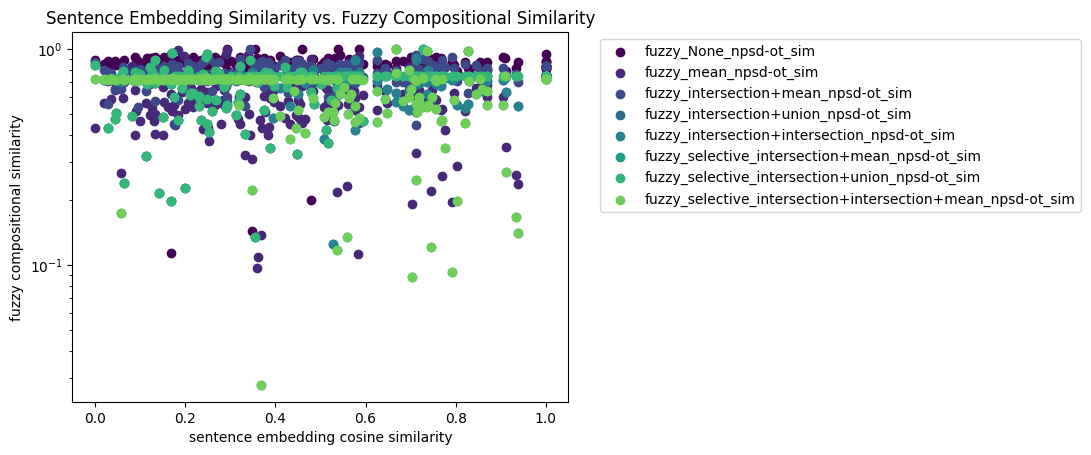

In [45]:
import numpy as np

cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(sims_df.columns)))
for i, col in enumerate(sims_df.columns):
  if col in ["sent_emb_cos_sim", "is_related"]:
    continue
  plt.scatter(
      x=sims_df["sent_emb_cos_sim"],
      y=sims_df[col],
      color=colors[i],
      label=col
  )

plt.xlabel("sentence embedding cosine similarity")
plt.ylabel("fuzzy compositional similarity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("log")
plt.title("Sentence Embedding Similarity vs. Fuzzy Compositional Similarity")
plt.show()

In [40]:
plt.figure(figsize=(16, 8))

plt.suptitle(f"Confusion Matrices for different embedding composition methods using {sim_metric} similarity\n")
plot_cols = [col for col in sim_eval_df.columns if col != "is_related" and not col.endswith("_pred")]
for i, col in enumerate(plot_cols):
    # Calculate confusion matrix
    cm = confusion_matrix(
        sim_eval_df['is_related'],
         (sim_eval_df[col] >= sim_eval_df[col].mean()).astype(int)
    )

    # Plot confusion matrix
    plt.subplot(3, 3, i+1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=['Unrelated', 'Related'],
        yticklabels=['Unrelated', 'Related']
    )
    plt.title(f'{col.replace("fuzzy_", "").replace(f"_{sim_metric}_sim", "").replace("_", " ")}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

In [41]:
sim_eval_df.head()

,fuzzy_None_npsd-ot_sim_pred,fuzzy_mean_npsd-ot_sim_pred,fuzzy_intersection+mean_npsd-ot_sim_pred,fuzzy_intersection+union_npsd-ot_sim_pred,fuzzy_intersection+intersection_npsd-ot_sim_pred,fuzzy_selective_intersection+mean_npsd-ot_sim_pred,fuzzy_selective_intersection+union_npsd-ot_sim_pred,fuzzy_selective_intersection+intersection+mean_npsd-ot_sim_pred,sent_emb_cos_sim_pred,is_related
0,True,True,False,False,False,True,False,True,False,0
1,False,True,True,True,True,True,True,True,False,0
2,True,False,True,True,True,True,True,True,False,0
3,True,False,True,False,False,False,True,False,False,1
4,True,True,True,True,True,False,True,False,True,0


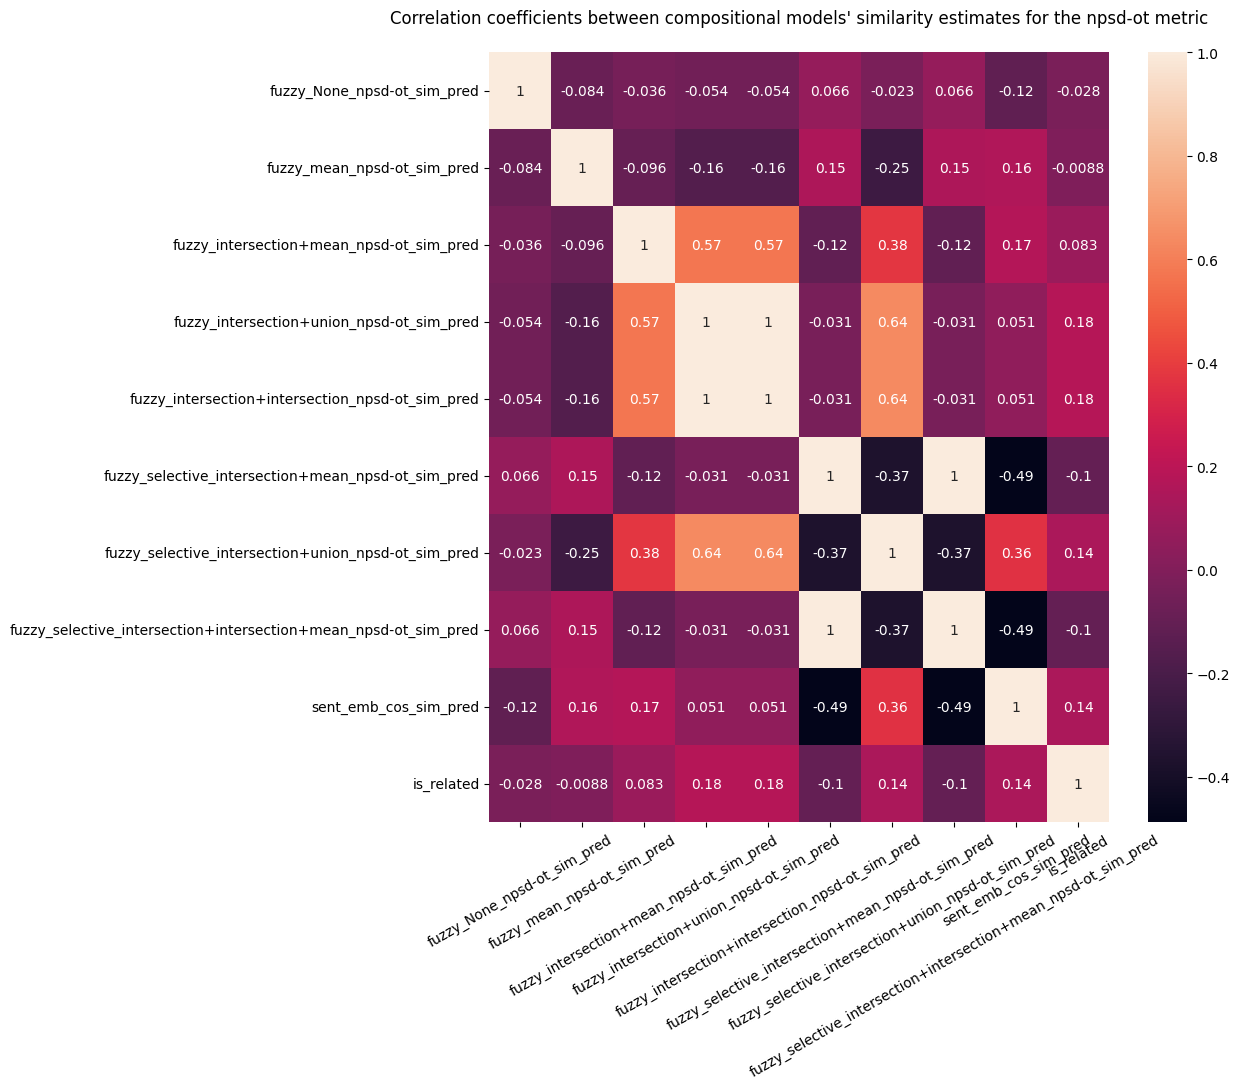

In [42]:
plt.figure(figsize=(10, 10))
prediction_cols = [c for c in sim_eval_df.columns if "_pred" in c] + ["is_related"]
ax = sns.heatmap(sim_eval_df[prediction_cols].corr(), annot=True)
ax.tick_params(axis='x', labelrotation=30)
plt.title(f"Correlation coefficients between compositional models' similarity estimates for the {sim_metric} metric\n")
plt.show()